# Parcel delineation using Sentinel-2

Authors:

* Kristof van Tricht (VITO)
* Jeroen Dries (VITO)
* Victor Verhaert (VITO)
* Manu Goudar (VITO)

Tuning:

* Kasper Bonte (VITO)
* Bart Driessen (VITO)

## Introduction

In this notebook we will be performing parcel delineation using Sentinel-2 data retrieved from- and processed on openEO.
The models are generated using a U-Net and are pretrained. So in this notebook, we are dealing with the inference part of training a model. We will however also show how you can retrieve features from openEO, so that you know how the entire workflow  looks like.

In [1]:
from pathlib import Path
import openeo
from openeo import processes as eop
import matplotlib.pyplot as plt
import xarray as xr

# openeo version
openeo.client_version()

'0.40.0'

In [2]:
## creates a output directory if it doesn't exist.
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [3]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

In [4]:
bbox = [5.0, 51.2, 5.1, 51.3]
year = "2021"   # in string format represents an temporal extent of 2021-01-01 to 2022-01-01

### Select usable observations
Compute cloud mask to mask the bands

In [5]:
scl = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=year,
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["SCL"],
    max_cloud_cover=10,
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)

Select bands with usable observations to compute ndvi by applying a strict cloud cover. Select data where the cloud cover is less than 10%.


In [6]:
s2_bands = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=year,             
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08"],
    max_cloud_cover=10,
)

s2_bands_masked = s2_bands.mask(cloud_mask)

## Calculate NDVI
The delineation will be estimated based on the NDVI. The `ndvi` process can be used for these calculations.

In [35]:
ndviband = s2_bands_masked.ndvi(red="B04", nir="B08")

Note that the openEO Python clients generates an openEO process graph, which is then sent to one of the backends selected by the platform based on the operations that you are using. 
This process graph is then executed on selected platform. 
However, if you want to inspect intermediate results, you can, for example using `ndviband.download(...)` like below.
Executing this line will allow you to inspect the NDVI images. 


In [ ]:
ndviband.download(base_path / "ndvi.nc")


The intermediate result (here only 3 of them are ploted) of the NDVI looks as shown below:

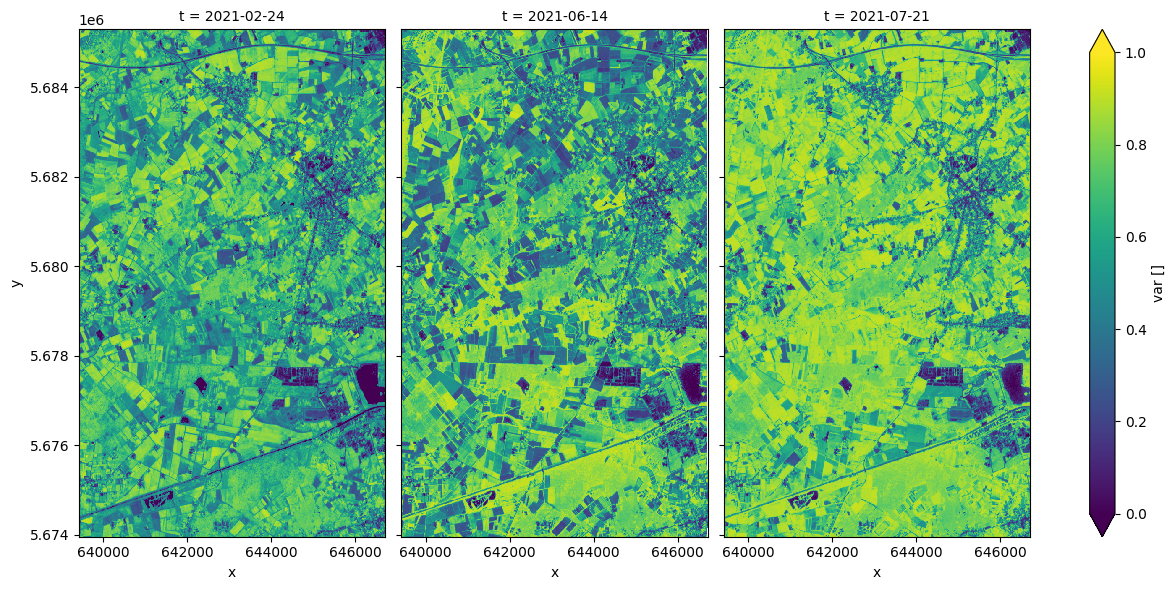

In [9]:
## Load your dataset
ndvi_data = xr.open_dataset(base_path / "ndvi.nc")

## Access the "var" variable
var = ndvi_data["var"]

# Select the 3 time steps
v1 = var.isnull().mean(dim=['x', 'y'])
var1 = var.sel(t = (v1.sortby(v1)).t[:3])

## plot data
var1.plot(x="x", y="y", col="t", col_wrap=3, cmap="viridis",
          vmin=0, vmax=1, aspect=0.66, size=6)

## Close the dataset
ndvi_data.close()

## Apply a neural network

We now apply a neural network, that requires 128x128 pixel 'chunks' input. To avoid discontinuities between neighboring chunks, we work with an overlap of 32 pixels in all directions. The U-Net itself is trained on an input size of (x,y,1), that is, just one grayscale channel as an input, which is just one NDVI tile. However, we are using 12 NDVI images as an input (the 12 images selected in the previous step). That is because we are doing inference using 3 different models, 4 times per model. The final prediction is then the median of all predictions per pixel.

As you may know, a U-Net just like any other CNN applies a filter over an image. This can be done using `apply_neighborhood`, an openEO process defined here: https://openeo.org/documentation/1.0/processes.html#apply_neighborhood .

Further preprocessing of the data and the inference logic of the models is coded in an UDF. 
UDF's are used to implement any custom code. It can therefore be used to quickly transfer code that you already wrote outside of openEO, or it can be used to implement features that are not present in openEO yet. It does however come at a cost of being slower than using openEO functionalities, due to optimization reasons.
UDF's are explained here: https://open-eo.github.io/openeo-python-client/udf.html

The pretrained models are converted to onnx models to allow for interoperability between different AI tools. More information on onnx and how to conveert your models from a specific framework can be found on [their website](https://onnx.ai/).
The onnxruntime package and other dependencies, used in `udf_segmentation.py`, have to be passed to the backend. This is done by passing a dependency archive as a job option, alongside the models.

**Important note**: The memory job options have been set to make make sure that the back-end has sufficient memory to perform the inference. Larger spatial/temporal extants might require higher memory settings.

In [ ]:
dependencies_url = (
    "https://artifactory.vgt.vito.be:443/auxdata-public/openeo/onnx_dependencies.zip"
)
models_url = "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/openeo/parcelDelination/BelgiumCropMap_unet_3BandsGenerator_Models.zip"
job_options = {
    'udf-dependency-archives': [
        f"{dependencies_url}#onnx_deps",
        f"{models_url}#onnx_models"],
    "driver-memory": "4G",
    "driver-memoryOverhead": "4G",
    "driver-cores": "1",
    "executor-memory": "2000m",
    "executor-memoryOverhead": "256m",
    "python-memory": "4G",
    "executor-cores": "1",
    "max-executors": "20",
    "logging-threshold": "info"
 }

In [11]:
## Apply the segmentation UDF using `apply_neighborhood`
## An overlap of 32px is used, resulting in a 128x128 pixel input

# specify the udf to use
segment_udf = openeo.UDF.from_file('udf_segmentation.py')
# segment_udf = openeo.UDF.from_url("https://raw.githubusercontent.com/Open-EO/openeo-community-examples/main/python/ParcelDelineation/udf_segmentation.py")
segmentationband = ndviband.apply_neighborhood(
    process=segment_udf,
    size=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 32, "unit": "px"},
        {"dimension": "y", "value": 32, "unit": "px"},
    ],
)

In [12]:
segmentation_job = segmentationband.create_job(
    title="segmentation_onnx_job", out_format="NetCDF", job_options=job_options
)
segmentation_job.start_and_wait()
segmentation_job.download_result(base_path / "delineation.nc")

0:00:00 Job 'j-250610202940469388cfcd19998f595f': send 'start'
0:00:14 Job 'j-250610202940469388cfcd19998f595f': created (progress 0%)
0:00:19 Job 'j-250610202940469388cfcd19998f595f': created (progress 0%)
0:00:26 Job 'j-250610202940469388cfcd19998f595f': created (progress 0%)
0:00:34 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:00:44 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:00:56 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:01:12 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:01:31 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:01:55 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:02:25 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:03:02 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:03:49 Job 'j-250610202940469388cfcd19998f595f': running (progress N/A)
0:04:48 Job 'j-250610202940469388cfcd19998f595f': running (progr

WindowsPath('results/delineation.nc')

The result of the U-Net is a map with more clearly defined boundaries, however the result is not optimal. We will therefore post-process our U-Net result by applying non-ML filters.


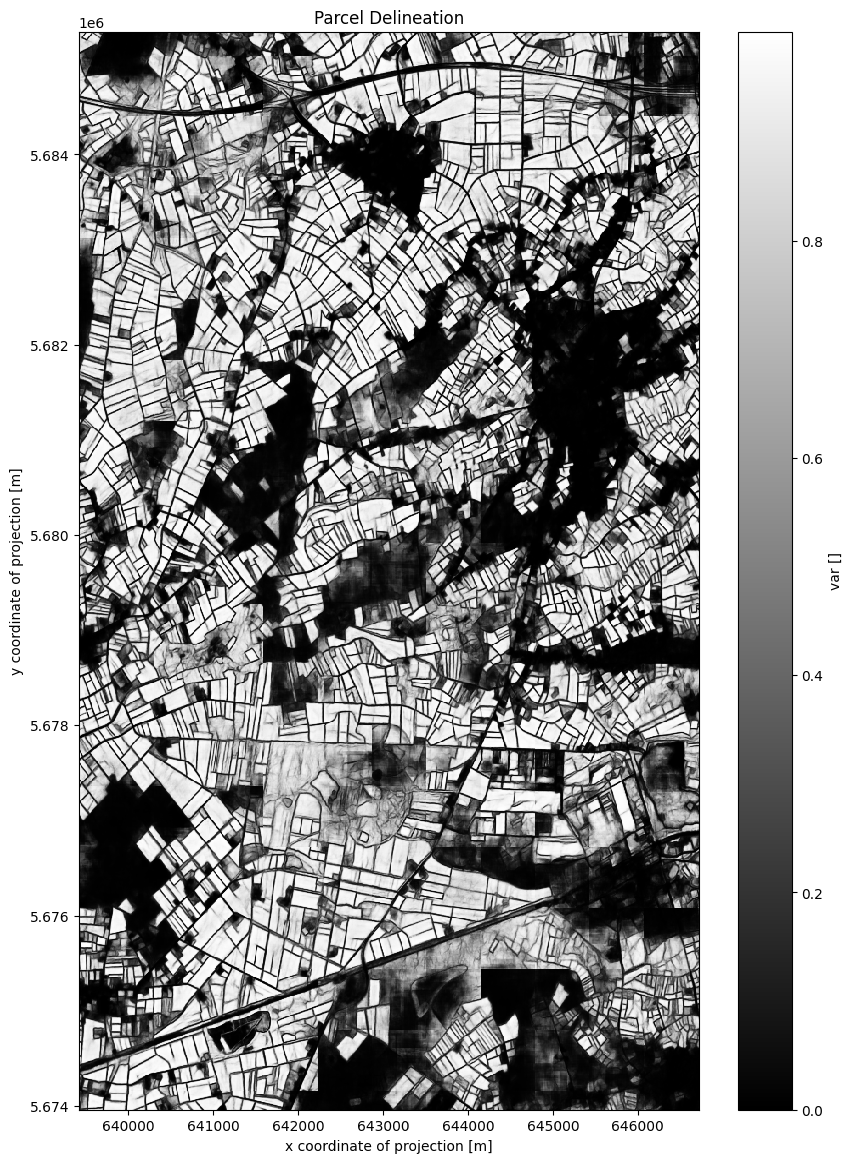

In [13]:
## Load your dataset
ds = xr.open_dataset(base_path / "delineation.nc")

## Access the "var" variable
var = ds["var"]

## Plot the data
var.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation")
plt.show()

## Close the dataset
ds.close()


## Segmentation postprocessing

We postprocess the output from the neural network using a sobel filter and Felzenszwalb's algorithm, which are then merged. This time, we work on larger chunks, to reduce the need for stitching the vector output.

In [28]:
## Apply the sobel felzenszwalb UDF using `apply_neighborhood`
segment_udf1 = openeo.UDF.from_file('udf_sobel_felzenszwalb.py')
# segment_udf1 = openeo.UDF.from_url("https://raw.githubusercontent.com/Open-EO/openeo-community-examples/refs/heads/main/python/ParcelDelineation/udf_sobel_felzenszwalb.py")
sobel_felzenszwalb = segmentationband.apply_neighborhood(
    process=segment_udf1,
    size=[
        {"dimension": "x", "value": 2048, "unit": "px"},
        {"dimension": "y", "value": 2048, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

In [50]:
sobel_felzenszwalb_job = sobel_felzenszwalb.create_job(
    title="sobel_felzenszwalb", out_format="NetCDF", job_options=job_options
)
sobel_felzenszwalb_job.start_and_wait()
sobel_felzenszwalb_job.download_result(base_path / "delineation_filtered.nc")

0:00:00 Job 'j-2506110813354bb4b7e35369f19a949b': send 'start'
0:00:14 Job 'j-2506110813354bb4b7e35369f19a949b': created (progress 0%)
0:00:19 Job 'j-2506110813354bb4b7e35369f19a949b': created (progress 0%)
0:00:26 Job 'j-2506110813354bb4b7e35369f19a949b': created (progress 0%)
0:00:33 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:00:43 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:00:56 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:01:11 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:01:31 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:01:55 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:02:25 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:03:02 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:03:49 Job 'j-2506110813354bb4b7e35369f19a949b': running (progress N/A)
0:04:47 Job 'j-2506110813354bb4b7e35369f19a949b': running (progr

WindowsPath('results/delineation_filtered.nc')

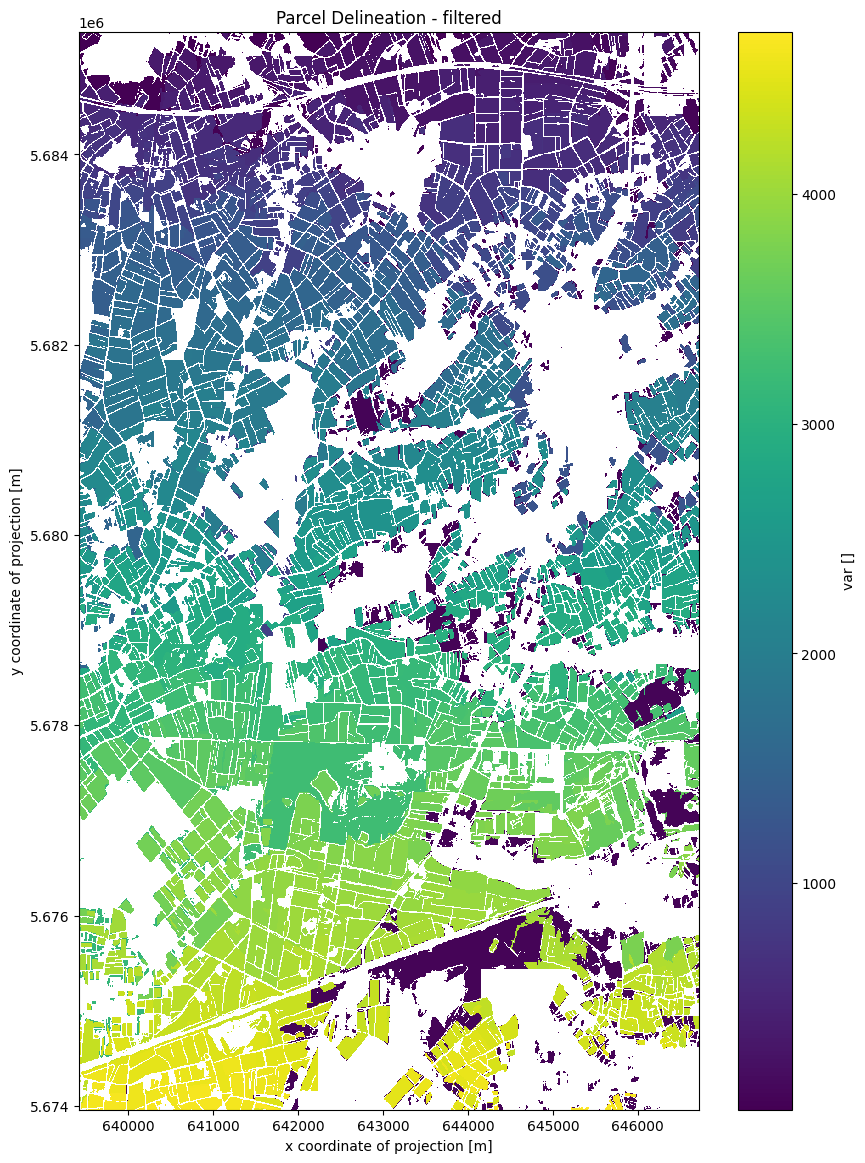

In [51]:
## Load your dataset
ds = xr.open_dataset(base_path / "delineation_filtered.nc")

## Access the "var" variable
var = ds["var"]

## Plot the data
var.plot(figsize=(10, 14), cmap="viridis")  # Use a colormap that suits your data
plt.title("Parcel Delineation - filtered")
plt.show()

## Close the dataset
ds.close()